In [21]:
#Johanna und Markus, Betreuer, Seminar, Martrikelnummer, WiSe 2020, Uni Augsburg

*DISCLAIMER: Dieses Tutorial verwendet das Codefolding Add-On aus Nbextensions. Sollten Sie dieses nicht installiert haben, empfehlen wir das jetzt zu tun, um das Tutorial bestmöglich nutzen zu können.*

*Unter dem folgenden Link finden Sie eine ausführliche Anleitung
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html.
Achten Sie darauf den Notebook Server nach der Installation neu zu starten.* 

*Bitte aktivieren Sie die Zeilennummerierung in Ihrem Notebook, indem Sie den Reiter "View" anklicken und "Toogle Line Numbers" auswählen.*

In [22]:
from copy import deepcopy
import sys
import matplotlib.pyplot as plt

# Hier: Bibliotheken laden, Disclaimer: Eventuell zuerst mit pip install installieren

# Tourenplanung für Ride-Sharing-Dienstleister

In [23]:
# Ride Sharing Erklären, Uber Pool

Ein spezielles Tourenplanungsproblem, dass sich mit der Planung von Touren für Ride-Sharing-Dienstleister befasst ist das Dial-a-ride Problem (DARP). Dieses unterscheidet sich von anderen Tourenplanungsproblem zunächst darin, dass sowohl Pickups als auch Dropoffs geplant werden. Außerdem entsteht sich durch das spezielle Förderungsgut "Kunde" eine paarweise Verbindung zwischen Pickups und Dropoffs. Im Gegensatz zu einem homogenen Gut kann ein Drop-off nicht von einem beliebigen Pick-up bedient werden [1]. Außerdem ergeben sich durch die Beförderung von Kunden weitere, zu berücksichtigende Kriterien, wie z.B. die im Fahrzeug verbrachte Zeit [2].

Eine Standarddefinition des DARP kommt von Cordeau und Laporte [2]:
<center>"In the dial-a-ride problem (DARP), $n$ users specify transportation requests between given origins and destinations. Users may provide a time window on their desired departure or arrival time, or on both. Transportation is supplied by a fleet of $m$ vehicles based at a common depot. The aim is to design a set of least cost vehicle routes capable of accommodating all requests, under a set of constraints." [2, p.1]</center>

Im Weiteren beschäftigen wir uns mit einer vereinfachten Version des dynamischen DARPs (DDARP), wie es von Haferkamp und Ehmke [3] vorgestellt wird. Da die zukünftigen Kundenanfragen nicht bekannt sind, müssen beim Eintreffen jeder einzelnen Anfrage zwei Planungsentscheidung getroffen werden:
  1. Wird der Kunde akzeptiert? $\longrightarrow$ **Akzeptanzentscheidung**
  2. Und wenn ja, wie sieht der neue Tourenplan aus? $\longrightarrow$ **Routingentscheidung**

Der Zielfunktionswert der Akzeptanzrate soll durch effizientere Tourenplanung erhöht werden. Um das zu erreichen, schlagen Haferkamp und Ehmke vor, zukünftige Kundenanfragen zu antizipieren und diese mit in die Planungsentscheidungen einzubeziehen.

Es werden vier Ausprägungen von Antizipation betrachtet:
1. **None Anticipatory/ Myopisch**: Zukünftige Kunden werden nicht beachtet. Jeder Kunde der in den Tourenplan eingefügt werden kann, wird akzeptiert. Der Routenplan wird für alle noch nicht ausgeführten Kunden neu erstellt.
2. **Anticipatory Acceptance**: Zukünftige Kunden werden beachtet. Bei jeder Anfrage wird geprüft, ob sie unter Berücksichtigung zukünftiger Kunden vorteilhaft ist. Wenn nicht, wird sie abgelehnt. Der Routenplan wird für alle noch nicht ausgeführten Kunden neu erstellt.
3. **Anticipatory Routing**: Zukünftige Kunden werden beachtet. Jeder Kunde der in den Tourenplan eingefügt werden kann, wird akzeptiert. Annahme: Plannung für den nächsten Tag. Bei der Optimierung des Routenplans werden alle Kunden beachtet, auch die die bei einer Planung für den selben Tag schon bedient worden wären. 
4. **Fully Anticipatory**: Kombination aus Anticipatory Acceptance und Anticipatory Routing. Bei jeder Anfrage wird geprüft, ob sie unter Berücksichtigung zukünftiger Kunden vorteilhaft ist. Wenn nicht, wird sie abgelehnt. #Annahme: Plannung für den nächsten Tag. Bei der Optimierung des Routenplans werden alle Kunden beachtet, auch die die bei einer Planung für den selben Tag schon bedient worden wären.#

In Teil 1 beginnen wir mit der detailierten Problemdefinition, die wir anhand eines Beispiels veranschaulichen. In Teil 2 folgt die Einführung der zwei für die Problemlösung wesentlichen Methoden, die Large Neighbourhood Search (LNS) und die Parallel Insertion Heuristic. Damit lösen wir unser Beispielproblem. Anschließend folgt in Teil 3 ein Ausblick über weitere Anwendungen des DDARPs.

Bei allem orientieren wir uns, wenn nicht anders angegeben, an Haferkamp und Ehmke [3]. Ziel ist es nicht deren Experiment nachzustellen, sondern ein "Proof of Concept" für ihr Vorgehen zu erhalten.

### 1.1 - Kundenanfragen

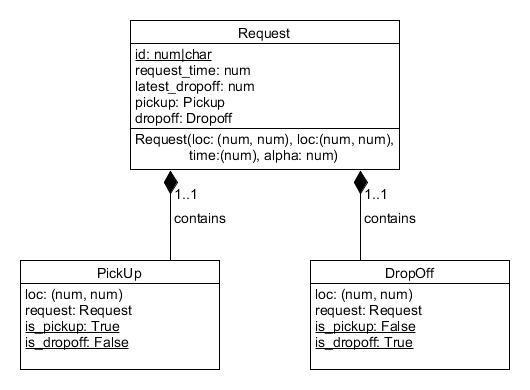

Eine Kundenanfrage $r$ (*request*) ist in der Menge der Kundenanfragen $\mathcal{R}$ ($r \in \mathcal{R}$) enthalten. Jede Kundenanfrage hat eine Empfangszeit $t_r$ (*receiving time*). Sie beschreibt den Zeitpunkt, zu dem der Kunde eine Anfrage nach einer Fahrt des Ride-Sharing-Anbieters stellt. 

Der Kunde frägt hierbei eine Fahrt von einem Startort $p_r$ (*Pick-Up*) zu einem Zielort $d_r$ (*Drop-Off*) an. Die Orte werden durch Klassen repräsentiert, die die Koordinaten des Ortes ($x, y$) beinhalten.

Die Fahrt muss innerhalb des Zeitfensters [$t_r, m_r$] (*time window*) durchgeführt werden. Der früheste Abholzeitpunkt wird durch die Empfangszeit der Kundenanfrage $t_r$ festgelegt. Vorausbuchungen sind somit nicht möglich. Der späteste Ankunftszeitpunkt des Kunden am Zielort $m_r = t_r + c_{p_r,d_r} + \alpha$ ergibt sich aus der Empfangszeit der Anfrage $t_r$, der euklidischen Distanz zwischen dem Start- und dem Zielort $c_{p_r,d_r}$ (*distance*) und $\alpha$. Der Parameter $\alpha$ bezeichnet die vom Kunden maximal tolerierte Verzögerungszeit, die durch Wartezeiten und abweichende Touren durch Bedienung anderer Kunden entsteht.

In [24]:
# Code-Beispiel

Auf Bedienzeiten, etwa die Einstiegsdauer und die Verifizierung des Kunden wird wegen der Einfachheit verzichtet.

In [25]:
class Request:

    # Klassenübergreifende Zählvariable: Anzahl der erstellten Request-Objekte
    count = 0

    def __init__(self, pickup_loc, dropoff_loc, request_time, alpha):
        # Erzeuge einzigartige ID für jedes Request-Objekt und inkrementiere Zählvariable
        Request.count += 1
        self.id = Request.count
        # Empfangszeit der Anfrage und frühester Abholzeitpunkt beim Startort
        self.request_time = request_time
        # Spätest mögliche Ankunftszeit des Kunden am Zielort
        self.latest_dropoff = request_time + distance(pickup_loc, dropoff_loc) + alpha
        # Zur Anfrage zugehörige Start- und Zielorte
        self.pickup = PickUp(pickup_loc, self)
        self.dropoff = DropOff(dropoff_loc, self)

class PickUp:
    is_pickup = True
    is_dropoff = False

    def __init__(self, loc, request):
        # Koordinaten (num, num) des Startortes
        self.loc = loc
        # Zugehörige Kundenanfrage
        self.request = request

class DropOff:
    is_pickup = False
    is_dropoff = True

    def __init__(self, loc, request):
        # Koordinaten (num, num) des Zielortes
        self.loc = loc
        # Zugehörige Kundenanfrage
        self.request = request

# Distanz (in Zeiteinheiten) zwischen zwei Orten loc1 und loc2
# Hier: euklidische Distanz. Das Funktioninnere kann durch andere Distanzmaße ersetzt werden.
def distance(loc1, loc2):
    return ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5

### 1.2 - Touren

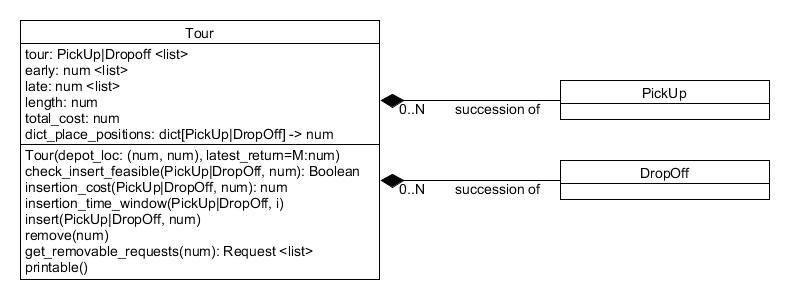

Eine Tour $v$ entspricht der geplanten Fahrt eines Vehikels des Ride-Sharing-Anbieters. Sie ist in der Menge der Touren $\mathcal{V}$ ($v \in \mathcal{V}$) enthalten. Die Kapazität jedes Vehikels ist unbeschränkt und die Vehikel unterscheiden sich nicht voneinander. Auf die Kapazitätsbeschränkung kann verzichtet werden, da die Kundenanfragen kurze Zeitfenster aufweisen und es somit unwahrscheinlich ist, viele Kunden gleichzeitig in einem Fahrzeug unterbringen zu können.

Jede Tour beginnt zum Zeitpunkt 0 und wird mit den Koordinaten der Startposition des Fahrzeugs (*depot*) initalisiert. Die anfängliche geplante Tour besteht aus einer Rundreise, die mit diesem Depot beginnt und endet. In Folge des heuristischen Verfahrens werden die Startorte $p_r$ und Endorte $d_r$ der Kundenanfragen $r$ in die Touren eingefügt (*insert*) und entfernt (*remove*), wobei die Liste *tour* die Abfolge der Orte darstellt. Damit ein Ort in die Tour in einer Position einfügbar ist, muss der feasibility-check (*check_insert_feasbile*) bestanden werden. 

Zum einen müssen die Zeitfenster jeder Kundenanfragen innerhalb der Tour berücksichtigt werden. Hierzu werden die frühesten und spätesten möglichen Besuchszeiten der Orte innerhalb der Tour mit $e_{p_r}, e_{d_r}, l_{p_r}$ und $l_{d_r}$ (*early*, *late*) festgehalten. Die tatsächlich geplante Besuchszeit der Orte $z_{p_r}, z_{d_r}$ entspricht der frühestmöglichen Besuchszeiten $e_{p_r}, e_{d_r}$ (*early*). 

Zudem wird die Anzahl der Orte der Tour (*length*) und die Gesamtreisezeit der Tour (*total_cost*) festgehalten.

In [26]:
class Tour:

    def __init__(self, depot_loc=(0, 0), M=sys.maxsize):
        # Erstelle Pseudo-Request depot. depot_loc ist Start- und Zielstandort
        depot = Request(depot_loc, depot_loc, 0, M)
        Request.count -= 1
        depot.id = 'D'
        # Tour: Abfolge von Pickups und Dropoffs, Tour beginnt und endet mit dem Depot
        self.tour = [depot.pickup, depot.dropoff]
        # Early: Frühest mögliche und geplante Besuchszeit des Standortes in Tour. 
        self.early = [0, 0]
        # Late: Spätest möglich geplante Besuchszeit
        self.late = [M, M]
        # Length: Länge der Tour
        self.length = 2
        # Gesamtkosten der Tour
        self.total_cost = 0
        # Positionen der Standorte der Tour
        self.dict_place_positions = {}

    # Check: Ist der PickUp/DropOff in Position i der Tour einfügbar?
    def check_insert_feasible(self, place, i):
        p_id = place.request.id
        temp = [(elem.is_pickup, elem.request.id) for elem in self.tour]
        # DropOff muss in die gleiche Tour wie der PickUp eingefügt
        # UND DropOff muss nach dem Pickup eingefügt werden.
        if place.is_dropoff and ((True, p_id) not in temp[:i] or (False, p_id) in temp):
            return False
        # PickUp ist nicht vor dem DropOff einfügbar
        if place.is_pickup and ((False, p_id) in temp[:i] or (True, p_id) in temp):
            return False
        # Die Zeitfenster aller Ort der Tour müssen eingehalten werden. 
        # Verletzt, falls e > l
        e, l = self.insertion_time_window(place, i)
        return e <= l
        
    # Berechne anfallende Einfügekosten, falls Pick-Up / Drop-Off place in Position i eingefügt wird
    def insertion_cost(self, place, i):
        return (distance(self.tour[i-1].loc, place.loc) + distance(place.loc, self.tour[i].loc)
                - distance(self.tour[i-1].loc, self.tour[i].loc))

    # Berechnen des Zeitfensters des Ortes, falls es in die Position i der Tour eingefügt wird
    # Entnommen aus: Campbell and Savelsbergh (2004)ingefügt wird
    def insertion_time_window(self, place, i):
        e = max(place.request.request_time, self.early[i-1]) + distance(self.tour[i-1].loc, place.loc)
        l = min(place.request.latest_dropoff, 
                self.late[i] - distance(place.loc, self.tour[i].loc))
        return e, l

    # Füge den Ort place in Position i der Tour ein
    def insert(self, place, i):
        # aktualisiere die Gesamtkosten der Tour
        self.total_cost += self.insertion_cost(place, i)
        # Einfügen von place in die Position i der Liste tour
        self.tour.insert(i, place)
        # Die Anzahl der Orte der Tour vergrößert sich
        self.length += 1
        # Berechne Zeitfenster des neuen Ortes und füge es in early und late ein
        e, l = self.insertion_time_window(self.tour[i], i)
        self.early.insert(i, e)
        self.late.insert(i, l)
        # Update der Zeitfenster (late) der Orte vor dem neuen Ort
        for k in range(i, -1, -1):
            self.late[k] = min(self.late[k], self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        # Update der Zeitfenster (early) der Orte nach dem neuen Ort
        for k in range(i+1, self.length):
            self.early[k] = max(self.early[k], self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
        # Update der Positionen der Orte nach dem neuen Ort im Dictionary:
        for key in self.dict_place_positions:
            if self.dict_place_positions[key] >= i:
                self.dict_place_positions[key] += 1
        # Einfügen der Position des neuen Ortes ins Dictionary
        self.dict_place_positions[place] = i
    
    # entferne den PickUp/DropOff auf Position i der Tour
    def remove(self, i):
        place = self.tour[i]
        # Lösche den Ort place von tour, early, late und dem Dictionary
        del self.tour[i]
        del self.early[i]
        del self.late[i]
        del self.dict_place_positions[place]
        # Reduziere die Gesamtkosten der Tour um die Einfügekosten des entfernten Ortes
        self.total_cost -= self.insertion_cost(place, i)
        # Reduziere die Anzahl der Orte der Tour
        self.length -= 1
        # Berechne die Zeitfenster neu: Early - vorwärts, Late - rückwärts
        for k in range(1, self.length):
            self.early[k] = max(self.tour[k].request.request_time + distance(self.tour[k-1].loc, self.tour[k].loc), 
                self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
        for k in range(self.length-2, -1, -1):
            self.late[k] = min(self.tour[k].request.latest_dropoff, 
                self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        # Reduziere die Position im Dictionary für die nachfolgenden Orte
        for key in self.dict_place_positions:
            if self.dict_place_positions[key] >= i:
                self.dict_place_positions[key] -= 1
    
    # Gebe die Kundenanfragen aus, die zum Zeitpunkt time aus der Tour entfernbar sind
    # entfernbar: Kundenanfragen, deren Startort und Zielort nach time liegen UND noch nicht angefahren wurden
    def get_removable_requests(self, time):
        result = []
        # v: Position der Tour, die im Zeitpunkt time als nächstes bedient / angefahren wird
        v = len([e for e in self.early if e <= time])
        # Startort auf Position v => Startort wird als nächstes angefahren und ist somit nicht entfernbar,
        # da der nächste angefahrene Ort nicht abrupt änderbar.
        # Folglich müssen sowohl der Startort, als auch der Zielort > v sein
        for key in self.dict_place_positions:
            if (key.is_pickup 
                and self.dict_place_positions[key] > v 
                and self.dict_place_positions[key.request.dropoff] > v):
                result.append(key.request)
        return result
    
    # Gebe eine Liste aus mit der Abfolge von: (ID, Koordinaten, früheste | geplante Besuchszeit, Art des Ortes)
    def printable(self):
        result = []
        for i in range(self.length):
            if i == 0 or i == self.length-1:
                typ = "D"
            elif self.tour[i].is_pickup:
                typ = "PU"
            else:
                typ = "DO"
            result.append((self.tour[i].request.id, 
                           self.tour[i].loc, 
                           round(self.early[i], 2), 
                           #round(self.late[i], 2), 
                           typ))
        return result

#### 1.2.1 - Einfügekosten

Nach der Maximierung der Akzeptanzquote ist die Minimierung der Gesamtreisedauer (*total_cost*) das zweite Ziel. Bei gleicher Anzahl von akzeptierten Kundenanfragen, wird der Tourenplan mit der geringeren Gesamtreisedauer bevorzugt. Ihre Berechnung erfolgt anhand der Einfügekosten (*insertion_cost*). Beim Einfügen eines neuen Ortes (*neu*) auf die Position $i$ der Tour werden die Einfügekosten wie folgt berechnet und zu den *total_cost* hinzugefügt. 

Gleichung der Einfügekosten:
$c_{insert} = c_{tour_{i-1}, neu} + c_{neu, tour_{i}} - c_{tour_{i-1}, tour_{i}}$ 

**Beispiel:** Beim Einfügen des Ortes (3, 0) auf Position 2 in die Beispieltour (0, 0), (3, 4), (0, 0) mit der Reisedauer $total\_cost =$ 10 Zeiteinheiten ergibt sich eine neue Tour (0, 0), (3, 4), (3, 0), (0, 0). 

Die Einfügekosten betragen im Beispiel $c_{(3, 4), (3, 0)} + c_{(3, 0), (0, 0)} - c_{(3, 4), (0, 0)} =$ 4 + 3 - 5 = 2 und die Gesamtreisedauer steigt somit von 10 auf 12 Zeiteinheiten.

In [27]:
# Beispielinstanz erstellen und vorbereiten
bsp_tour = Tour(depot_loc=(0, 0), M=100)
bsp_request = Request(pickup_loc=(3, 4), dropoff_loc=(3, 0), request_time=0, alpha=100)
bsp_tour.insert(bsp_request.pickup, 1)
print("Gesamtkosten vor Einfügen: ", 
      bsp_tour.total_cost)
print("Einfügekosten (3, 0) in Position 2: ", 
      bsp_tour.insertion_cost(bsp_request.dropoff, 2))
# Einfügen
bsp_tour.insert(bsp_request.dropoff, 2)
print("Gesamtkosten nach Einfügen: ", 
      bsp_tour.total_cost)

Gesamtkosten vor Einfügen:  10.0
Einfügekosten (3, 0) in Position 2:  2.0
Gesamtkosten nach Einfügen:  12.0


#### 1.2.2 - Zeitfenster

Bei der Erstellung der Touren müssen sie Zeitfenster [$t_r, m_r$] aller Kundenanfragen $r$ berücksichtigt werden. So darf ein Startort nicht vor der Empfangszeit der zugehörigen Anfrage $t_r$ angefahren werden und ein Zielort muss spätestens zur spätesten Ankunftszeit $m_r$ bedient werden. Das muss für alle Orte einer Tour gewährt sein. Hierfür wird für jeden Ort der Tour das Zeitfenster [$e_{ort}, l_{ort}$] definiert. Die Berechnung erfolgt angelehnt an Campbell und Savelsbergh (2004) wie folgt:

$e_{neu} = max(t_{neu}, e_{i-1}) + c_{i-1, neu}$

$l_{neu} = min(m_{neu}, l_i - c_{neu, i})$

Der früheste Besuchszeitpunkt $e_{neu}$ wird in Abhängigkeit der frühesten Besuchszeitpunkt des vorigen Ortes $e_{i-1}$ und der Reisezeit von dem vorigen Ort zum neuen Ort $c_{i-1, neu}$ berechnet. Falls der vorige Kunde bereits besucht wurde und das Fahrzeug beim letzten Ort auf die Ankunft einer neuen Kundenanfrage wartet, ergibt sich die früheste Besuchszeit aus dem Zeitpunkt der neuen Kundenanfrage $t_{neu}$ und der Reisezeit $c_{i-1, neu}$. Hier unterscheidet sich das Vorgehen von dem von Campbell und Savelsbergh (2004), weil sie von einem statischen Problem ausgehen, in dem die frühesten Besuchszeiten $t_r$ aller Kundenanfragen bereits in vorhinein bekannt sind. Im dynamischen Fall wird die Kundenanfrage erst zum Zeitpunkt $t_r$ bekannt und die Reisezeit $c_{i-1, neu}$ muss somit berücksichtigt werden.

Der späteste Besuch des neuen Ortes $l_{neu}$ muss vor der spätesten tolerierten Ankunftszeit der neuen Kundenanfrage am Zielort $m_{neu}$ und der spätesten möglichen Ankunftszeit des nächsten Ortes $l_i$ unter Berücksichtigung der Reisedauer $c_{neu, i}$ erfolgen. Ist es nicht möglich, die früheste Besuchszeit $e_{neu}$ vor der spätesten Besuchszeit $l_{neu}$ einzubringen ($e > l$), dann können die Zeitfenster der anderen Kundenanfragen [$t_r, m_r$] nicht eingehalten werden und die gesamte Tour ist nicht durchführbar.

Zwar ist es möglich, die Orte in jedem Zeitpunkt zwischen [$e_{ort}, l_{ort}$] zu besuchen, ohne dass sich die Durchführbarkeit der Tour und die Gesamtreisedauer ändert, jedoch wird hier angenommen, dass jeder Ort zu ihrer frühesten möglichen Besuchszeit $e_{ort}$ besucht wird ($z_{ort} = e_{ort}$). Grund hierfür ist, dass im dynamischen Kontext so besser auf zukünftige, unbekannte Kundenanfragen $r$ reagiert werden kann.  

Wird ein neuer Ort auf Position $i$ in die Tour eingefügt, müssen die Zeitfenster [$e_{ort}, l_{ort}$] der anderen Orte wie folgt angepasst werden.

für Position $k = i - 1$ bis $0$:
* $l_k = min(l_k, k_{k+1} - c_{k, k+1})$

Die spätesten Besuchszeiten der vorigen Orte vor dem neuen Ort können sich ändern und werden aktualisiert.

für Position $i$ bis $n + 1$:
* $e_k = max(e_k, e_{k-1} + c_{k-1, k})$

Ebenso können sich die frühesten Besuchszeiten der folgenden Orte nach dem neuen Ort ändern und werden ebenfalls aktualisiert.

Auch nach dem Entfernen eines Ortes aus der Tour werden die Zeitfenster aktualisiert.

**Beispiel:** Ausgehend von der vorigen Tour (0, 0), (3, 4), (3, 0), (0, 0) wird der Ort (0, 4) mit der Ankunftszeit $r_{neu}=$ 8 auf Position 2 der Tour gesetzt.

Das Zeitfenster [11, 92] ergibt sich aus max(8, 5) + 3 = 11 und min(110, 97) - 5 = 87.

In [28]:
bsp_request = Request(pickup_loc=(0, 4), dropoff_loc=(0, 2), request_time=8, alpha=100)
print("Vor einfügen - e_i: " + 
      str(bsp_tour.early))
print("Vor einfügen - l_i: " + 
      str(bsp_tour.late))
print("Zeitfenster des Ortes (1, 2) in Position 2: " +
     str(bsp_tour.insertion_time_window(bsp_request.pickup, 2)))
bsp_tour.insert(bsp_request.pickup, 2)
print("Nach einfügen - e_i: " + 
      str(bsp_tour.early))
print("Nach einfügen - l_i: " + 
      str(bsp_tour.late))

Vor einfügen - e_i: [0, 5.0, 9.0, 12.0]
Vor einfügen - l_i: [88.0, 93.0, 97.0, 100]
Zeitfenster des Ortes (1, 2) in Position 2: (11.0, 92.0)
Nach einfügen - e_i: [0, 5.0, 11.0, 16.0, 19.0]
Nach einfügen - l_i: [84.0, 89.0, 92.0, 97.0, 100]


#### 1.2.3 - Durchführbarkeit der Tour

Damit eine Tour durchführbar ist, müssen die folgenden vier Punkte gelten:

1. Der Startort und der Endort einer Kundenanfrage müssen in der gleichen Tour liegen.
2. Der Endort einer Kundenanfrage muss nach ihrem Startort bedient werden.
3. Bereits zu einem Zeitpunkt bediente Kunden, sowie Kunden, die sich derzeit in einem Fahrzeug befinden und Kundenanfragen, die derzeit angefahren werden, können nicht aus der Tour entfernt werden.
4. Die Bedienzeit jedes Ortes muss sich in dem gültigen Zeitfenster [$e_{ort}, l_{ort}$] befinden

**Beispiel :** In die vorige Tour [Depot: (0, 0), Pick-Up_1: (3, 4), Pick-Up_2: (0, 4), Drop-Off_1(3, 0), Depot: (0, 0)] wird der Drop-Off der Kundenanfrage 2 (0, 2) an verschiedenen Positionen eingesetzt.

In [9]:
# Drop-Off_2 (0, 2) auf Position 1 setzen
# False: Pick-Up vor zugehörigem Dro-Off
bsp_tour.check_insert_feasible(bsp_request.dropoff, 1)

False

In [10]:
# Drop-Off_2 (0, 2) auf Position 1 einer neuen Tour (0, 0), (0, 0) setzen
# False: Drop-Off in einer anderen Tour als der Pick-Up
bsp_tour2 = Tour((0, 0))
bsp_tour2.check_insert_feasible(bsp_request.dropoff, 1)

False

In [11]:
# Drop-Off_2 (0, 2) auf Position 3 der ersten Tour setzen
# True: Drop-Off nach dem Pick-Up einsetzbar und Zeitfenster eingehalten
bsp_tour.check_insert_feasible(bsp_request.dropoff, 3)

True

### 2.3 - Entscheidungsepochen

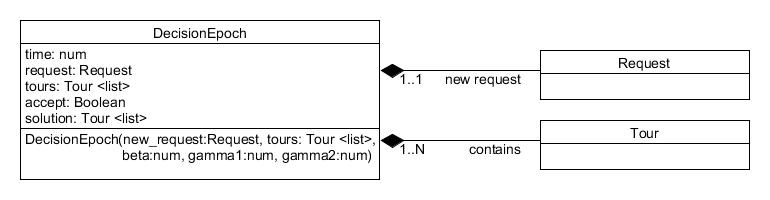

Jede Entscheidungsepoche $k$ ($k \in \mathcal{K}$) wird durch die Ankunft einer neuen Kundenanfrage $r_k$ erzeugt. Sie ist durch ihren Zeitpunkt *time* charakterisiert, die der Ankunftszeit der neuen Kundenanfrage $t_r$ entspricht. Die Entscheidungsepochen sind für den dynamischen Fall essentiell, da sie jede Stufe des Entscheidungsprozesses abbildet. In der anfänglichen Stufe, die durch die erste Kundenanfrage ausgelöst wird, befinden sich alle Fahrzeuge in ihrem Startzustand am Depot und es gibt keine ausstehenden Kundenanfragen. In jeder neuen Stufe stellt sich die Frage, ob der Ride-Sharing-Anbieter die neue Kundenanfrage annimmt ($x_k=$ 1), oder ablehnt ($x_k=$ 0). Zudem muss der Ride-Sharing-Anbieter einen ausführbaren Tourenplan $y_k$ (*solution*) erstellen, der bis zur nächsten Entscheidungsepoche *k+1* gültig ist. Die Entscheidung in jeder Stufe ist von den bisher getroffenen Entscheidungen in den Vorepochen abhängig. Zudem müssen alle bisher akzeptieren Kundenanfragen erfüllt werden und die Durchführbarkeit der Touren muss gewährleistet werden (1.2.3), so können bisher bediente Kundenanfragen, sich in *time* in einem Fahrzeug sich befindete Kunden und Kunden, die derzeit von einem Fahrzeug angefahren werden, nicht aus einer Tour entfernt werden.


Das Ziel des Ride-Sharing-Anbieters ist es, durch die Wahl des Tourenplans und der Akzeptanzentscheidung eine optimale Politik über alle Epochen hinweg zu treffen, so dass die Akzeptanzquote über den gesamten Entscheidungsprozess maximiert wird und bei gleicher Akzeptanzquote, die Gesamtreisedauer minimiert wird.

In [12]:
class DecisionEpoch:

    def __init__(self, new_request, tours, beta, gamma1, gamma2):
        # Zeitpunkt der Entscheidungsepoche = Anfragezeitpunkt der neuen Anfrage
        self.time = new_request.request_time
        # Die neue Kundenanfrage
        self.request = new_request
        self.tours = deepcopy(tours)
        # Akzeptanzentscheidung: Wird die neue Kundenanfrage angenommen (accept = True)? 
        self.accept, self.solution = LNS(self, "accept", beta, gamma1, gamma2)
        # Re-Optimierung, falls vorige Kundenanfrage angenommen wurde
        if self.accept:
            self.tours = self.solution
            _, self.solution = LNS(self, "re-routing", beta, gamma1, gamma2)

### 2.4 - Ride-Sharing

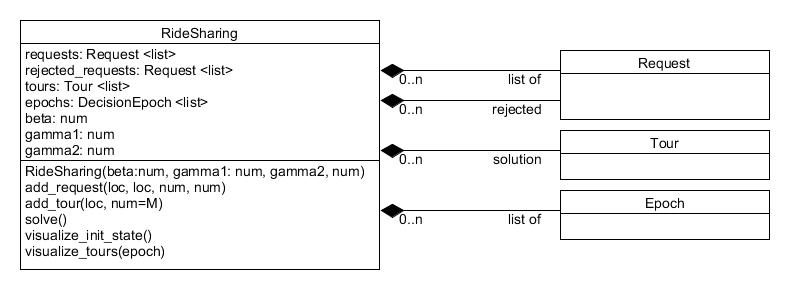

Die Klasse Ride-Sharing dient zur Repräsentation einer Instanz des Ride-Sharing-Problems. 

In [13]:
class RideSharing:

    # Füge eine neue Kundenanfrage zur Instanz hinzu
    def add_request(self, pickup_loc, dropoff_loc, request_time, max_waiting_duration):
        self.requests.append(Request(pickup_loc, dropoff_loc, request_time, max_waiting_duration))

    # Füge eine neue Tour zur Instanz hinzu
    def add_tour(self, depot_loc, latest_return=sys.maxsize):
        self.tours.append(Tour(depot_loc, latest_return))

    # Löse das Problem myopisch
    def solve(self):
        # Sortiere die Kundenanfragen nach ihrer Ankunftszeit und arbeite sie in dieser Reihenfolge ab
        self.requests = sorted(self.requests, key=lambda x: x.request_time)
        for request in self.requests:
            # Neue Kundenanfrage -> neue Entscheidungseopche
            new_epoch = DecisionEpoch(request, self.tours, self.beta, self.gamma1, self.gamma2)
            # Akuteller Routenplan nach dieser Eopche
            self.tours = new_epoch.tours
            self.epochs.append(new_epoch)
            # Wurde die Kundenanfrage in dieser Epoche angenommen?
            if new_epoch.accept == False:
                self.rejected_requests.append(new_epoch.request)
    
    # Scatter-Plot: Koordinaten der Startorte, der Zielorte und der Depots
    def visualize_init_state(self):
        # Ermittle Koordinaten der Startorte, Zielorte und der Depots
        x_pickup = [req.pickup.loc[0] for req in self.requests]
        y_pickup = [req.pickup.loc[1] for req in self.requests]
        x_dropoff = [req.dropoff.loc[0] for req in self.requests]
        y_dropoff = [req.dropoff.loc[1] for req in self.requests]
        x_tour = [tour.tour[0].loc[0] for tour in self.tours]
        y_tour = [tour.tour[0].loc[1] for tour in self.tours]
        # Füge Koordinaten zum Plot hinzu
        plt.plot(x_pickup, y_pickup,'o', label="PickUp")
        plt.plot(x_dropoff, y_dropoff, 'ro', label="DropOff")
        plt.plot(x_tour, y_tour, 'mo', label="TourDepot")
        # Füge Labels hinzu
        for i in range(len(self.requests)):
            plt.text((x_pickup[i]+0.1),(y_pickup[i]+0.1), self.requests[i].id)
            plt.text((x_dropoff[i]+0.1),(y_dropoff[i]+0.1), self.requests[i].id)
        for i in range(len(self.tours)):
            plt.text((x_tour[i]+0.1), (y_tour[i]+0.1), "D")
        # Skaliere Achsen dynamisch
        plt.axis([min(0, *x_pickup, *x_dropoff, *x_tour), max(0, *x_pickup, *x_dropoff, *x_tour)+1,
                min(0, *y_pickup, *y_dropoff, *y_tour), max(0, *y_pickup, *y_dropoff, *y_tour)+1])
        plt.grid()
        plt.legend()
        plt.show()
        
    # Erstelle Gantt-ähnliche Abbildung
    def visualize_tours(self, k=None, height=10):
        # Wahl: Den Tourenplan welcher Entscheidungsepoche darstellen
        # Standard: Tourenplan der letzten Epoche
        if k is None:
            k = len(self.epochs) - 1
        tours_temp = self.epochs[k].solution
        # Erstelle mehrere Plots (# Anzahl Touren + 1 (für abgelehnte Touren))
        fig, axs = plt.subplots(len(tours_temp)+1, figsize=(20, len(tours_temp)*4))
        # aktuelle Position des neuen Balkens
        current_y_pos = 5
        # Skalierung: Einheitliche Achsen für Subplots
        max_end_t = 0
        # Ein Subplot für jede Tour
        for i in range(len(tours_temp)):
            # Position der Kundenanfragen, Label
            y_ticks = []
            y_ticklabels = []
            requests_temp = []
            # Beschriftung der Tour: Nummer der Tour und Koordinaten
            tour_loc = tours_temp[i].tour[0].loc
            axs[i].set_ylabel(str(i+1) + ": " + str(tour_loc))
            # Ermittle Kundenanfragen der Tour
            for j in range(1, tours_temp[i].length-1):
                if tours_temp[i].tour[j].is_pickup:
                    requests_temp.append(tours_temp[i].tour[j].request)
            requests_temp = sorted(requests_temp, key=lambda x: x.request_time, reverse=True)
            # Ermittle Eigenschaften jeder Kundenanfragen für die Beschriftung
            for req in requests_temp:
                req_t = req.request_time
                end_t = req.latest_dropoff
                # für X-Achsen-Skalierung
                if end_t > max_end_t:
                    max_end_t = end_t
                pu_t = tours_temp[i].early[tours_temp[i].dict_place_positions[req.pickup]]
                do_t = tours_temp[i].early[tours_temp[i].dict_place_positions[req.dropoff]]
                r_id = req.id
                pu_loc = req.pickup.loc
                do_loc = req.dropoff.loc
                # Füge neues unterbrochenes Barchart hinzu
                # orange: Zeit vor Bearbeitung (Anfragezeit, Bedienzeit Startort)
                # blau: Zeit (Fahrzeit Startort zum Zielort)
                # orange2: Zeit nach Bearbeitung (Ankunft Zielort, letztmöglicher Ankunftszeitpunkt)
                axs[i].broken_barh([(req_t, pu_t-req_t), (pu_t, do_t-pu_t), (do_t, end_t-do_t)],
                                   (current_y_pos, height-1),
                                   facecolors=("tab:orange", "tab:blue", "tab:orange"))
                y_ticks.append(current_y_pos + 0.5*height)
                y_ticklabels.append("id:" + str(r_id) + ": " + str(pu_loc) + " " + str(do_loc))
                current_y_pos += height
            axs[i].set_yticks(y_ticks)
            axs[i].set_yticklabels(y_ticklabels)
        # Visualisiere die abgelehnten Kundenanfragen
        axs[i+1].set_ylabel("rejected requests")
        sorted_rejects = sorted(self.rejected_requests, key=lambda x: x.request_time, reverse=True)
        y_ticks = []
        y_ticklabels = []
        for reject in sorted_rejects:
            r_id = reject.id
            req_t = reject.request_time
            end_t = reject.latest_dropoff
            pu_loc = reject.pickup.loc
            do_loc = reject.dropoff.loc
            axs[i+1].broken_barh([(req_t, end_t-req_t)],
                               (current_y_pos, height-1),
                               facecolors="tab:orange")
            y_ticks.append(current_y_pos + 0.5*height)
            y_ticklabels.append("id:" + str(r_id) + ": " + str(pu_loc) + " " + str(do_loc))
            current_y_pos += height
        axs[i+1].set_yticks(y_ticks)
        axs[i+1].set_yticklabels(y_ticklabels)
        # x-Achsenskalierung dynamisch
        for ax in axs:
            ax.set_xlim(0, max_end_t*1.03)
        plt.show()
        
    def __init__(self, beta, gamma1, gamma2):
        Request.count = 0
        self.requests = []
        self.tours = []
        self.epochs = []
        self.rejected_requests = []
        self.beta = beta
        self.gamma1 = gamma1
        self.gamma2 = gamma2

In [14]:
def parallel_insertion(tours, requests, time=0, M=sys.maxsize):
    reject = []
    # Kunden = copy.deepcopy(fiktivekunden)
    
    while requests:
        pOpt = M 
        for j in range(len(requests)):
            for k in range(len(tours)):
                earl_pos = min(len([e for e in tours[k].early if e <= time])+1, tours[k].length-1)
                # spos: Position in Tour k, an der der Pickup des Kunden eingefügt wird
                for spos in range(earl_pos, tours[k].length):
                    if tours[k].check_insert_feasible(requests[j].pickup, spos):
                        skosten = tours[k].insertion_cost(requests[j].pickup, spos)
                        
                        # speichert die aktuell gültige Tour in einer temporären Variablen
                        tour_temp = deepcopy(tours[k])
                        
                        # füge den Pickup des Kunden vorübergehend in den Tourenplan ein und Update der Zeitfenster
                        tour_temp.insert(requests[j].pickup, spos)
                        
                        # Prüfe für alle Positionen im Tourenplan nach dem eingefügten Pickup ob es einen möglichen Drop-off gibt 
                        for epos in range(spos+1, tour_temp.length): 
                            if tour_temp.check_insert_feasible(requests[j].dropoff, epos):  
                                ekosten = tour_temp.insertion_cost(requests[j].dropoff, epos)
                                if skosten + ekosten < pOpt:
                                    reqOpt = requests[j] 
                                    tourOpt = tours[k] 
                                    sposOpt = spos
                                    eposOpt = epos
                                    pOpt = skosten + ekosten   
      
        if pOpt < M:   
            # Setze den Pickup und Drop-Off des Kunden ein und aktualisiere Zeitfenster
            tourOpt.insert(reqOpt.pickup, sposOpt)
            tourOpt.insert(reqOpt.dropoff, eposOpt)
            
            #Entferne den eigesetzten Kunden aus der Liste der noch ausstehenden Kunden
            requests.remove(reqOpt)         
        else:
            # Wenn kein Kunde den Feasibility mehr besteht, speichere die abgewiesenen Kunden und leere die Liste
            reject = deepcopy(requests)
            requests = []
   
    return tours, reject

In [15]:
from random import sample, randint
from math import floor, ceil

# Entferne zufällig zwischen gamma1 und gamma2 der entfernbaren Kundenanfragen und setze sie neu ein
def random_removal(tours, time, gamma1, gamma2):
    new_tours = deepcopy(tours)
    candidates = []
    # Ermittle entfernbare Kundenanfragen
    for i in range(len(new_tours)):
        for elem in new_tours[i].get_removable_requests(time):
            candidates.append((i, elem))
    removed = []
    # q: Anzahl der Kundenanfragen, die entfernt werden können
    q = len(candidates)
    # n: Anzahl der Kundenanfragen, die entfernt werden
    n = randint(floor(gamma1 * q), ceil(gamma2 * q))
    # Auswahl: Welche Kundenanfragen entferne ich zufällig
    to_remove = sample(candidates, n)
    # entferne Kundenanfragen
    for elem in to_remove:
        pos_pickup = new_tours[elem[0]].dict_place_positions[elem[1].pickup]
        pos_dropoff = new_tours[elem[0]].dict_place_positions[elem[1].dropoff]
        new_tours[elem[0]].remove(pos_dropoff)
        new_tours[elem[0]].remove(pos_pickup)
        removed.append(elem[1])
    return new_tours, removed
        

def LNS(epoch, type, beta, gamma1, gamma2):
    # w = w0
    plan_current = deepcopy(epoch.tours)
    # wbest = w0
    plan_best = deepcopy(epoch.tours)
    if type == "accept":
        unplanned = [epoch.request]
    else:
        unplanned = []
    all_inserted = False
    iteration = 0
    while iteration < beta:
        iteration += 1
        # w_new erzeugen
        plan_new, removed = random_removal(plan_current, epoch.time, gamma1, gamma2)
        unplanned += removed
        # füge entfernte Kundenanfragen und, falls noch nicht geschehen, neue Kundenanfrage ein
        plan_new, reject = parallel_insertion(plan_new, unplanned, epoch.time)
        # Gültigkeit: Alle Kundeneinfragen eingefügt
        if len(reject) == 0 and type == "accept":
            # Akzeptanzentscheidung --> w_best gefunden
            return True, plan_new
        elif len(reject) == 0 and type == "re-routing":
            # Tourenplan ist gültig -> w = w_new
            plan_current = plan_new
            cost_current = sum([tour.total_cost for tour in plan_current])
            cost_best = sum([tour.total_cost for tour in plan_best])
            # Falls geringere Gesamtreisezeit -> w_best = w_new
            if cost_current < cost_best:
                plan_best = plan_new
    return all_inserted, plan_best

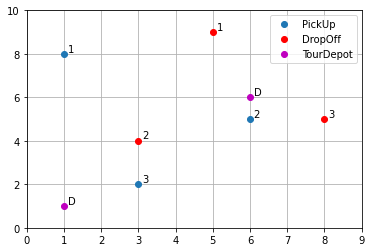

In [16]:
instance = RideSharing(10, 0.2, 0.8)
instance.add_tour((1, 1))
instance.add_tour((6, 6))
instance.add_request((1, 8), (5, 9), 1, 10)
instance.add_request((6, 5), (3, 4), 0, 10)
instance.add_request((3, 2), (8, 5), 0, 10)
instance.visualize_init_state()

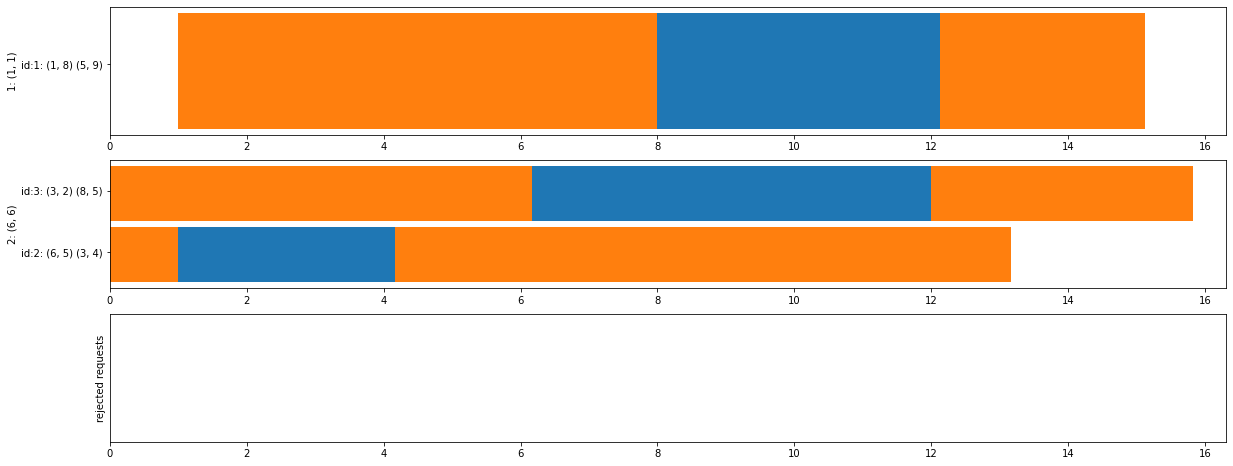

In [17]:
instance.solve()
instance.visualize_tours()

In [18]:
n = 5 # Anzahl der Fahrzeuge
m = 50 # Anzahl der Anfragen
low = 0 # Kleine mögliche Koordinate
up = 20 # Größte mögliche Koordinate
end = 100 # Späteste mögliche Anfragezeitpunkt
beta = 10 # Anzahl der Iterationen der LNS
g1 = 0.3 # Wie viel Prozent der wartenden Kundenanfragen in einer Iteration der LNS minimal entfernen
g2 = 0.7 # Wie viel Prozent der wartenden Kundenanfragen in einer Iteration der LNS maximal entfernen
a = 25 # Maximal tolerierte Verzögerungszeit jedes Kunden

groß = RideSharing(beta, g1, g2)
for i in range(n):
    groß.add_tour((randint(low, up), randint(low, up)))
for i in range(m):
    groß.add_request((randint(low, up), randint(low, up)), (randint(low, up), randint(low, up)), randint(0, end), a)
groß.solve()

[('D', (7, 2), 0, 'D'), (8, (11, 4), 20.47, 'PU'), (8, (16, 2), 25.86, 'DO'), (46, (16, 0), 27.86, 'PU'), (36, (4, 0), 39.86, 'PU'), (36, (5, 3), 43.02, 'DO'), (28, (0, 6), 48.85, 'PU'), (46, (0, 7), 49.85, 'DO'), (6, (6, 2), 57.66, 'PU'), (28, (17, 15), 74.69, 'DO'), (6, (6, 20), 86.77, 'DO'), (24, (12, 20), 92.77, 'PU'), (24, (7, 2), 111.45, 'DO'), ('D', (7, 2), 111.45, 'D')]
6
[('D', (4, 7), 0, 'D'), (42, (10, 6), 6.08, 'PU'), (43, (12, 12), 12.41, 'PU'), (42, (2, 15), 22.85, 'DO'), (43, (7, 9), 30.66, 'DO'), (27, (0, 15), 39.88, 'PU'), (27, (0, 5), 49.88, 'DO'), (14, (1, 13), 59.06, 'PU'), (38, (6, 13), 64.06, 'PU'), (14, (18, 12), 76.1, 'DO'), (20, (18, 11), 77.1, 'PU'), (38, (12, 8), 83.81, 'DO'), (20, (5, 5), 91.43, 'DO'), (45, (6, 0), 96.53, 'PU'), (45, (8, 2), 99.36, 'DO'), (4, (14, 9), 108.57, 'PU'), (23, (9, 18), 118.87, 'PU'), (4, (9, 19), 119.87, 'DO'), (23, (13, 19), 123.87, 'DO'), ('D', (4, 7), 138.87, 'D')]
9
[('D', (19, 13), 0, 'D'), (3, (5, 17), 20.56, 'PU'), (30, (12

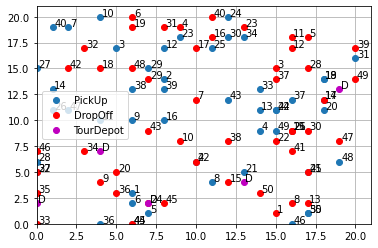

[9, 10, 15, 19, 26, 32, 40, 47, 48]


In [19]:
for tour in groß.tours:
    print(tour.printable())
    print(tour.length//2 - 1)

groß.visualize_init_state()
print(sorted([elem.id for elem in groß.rejected_requests]))

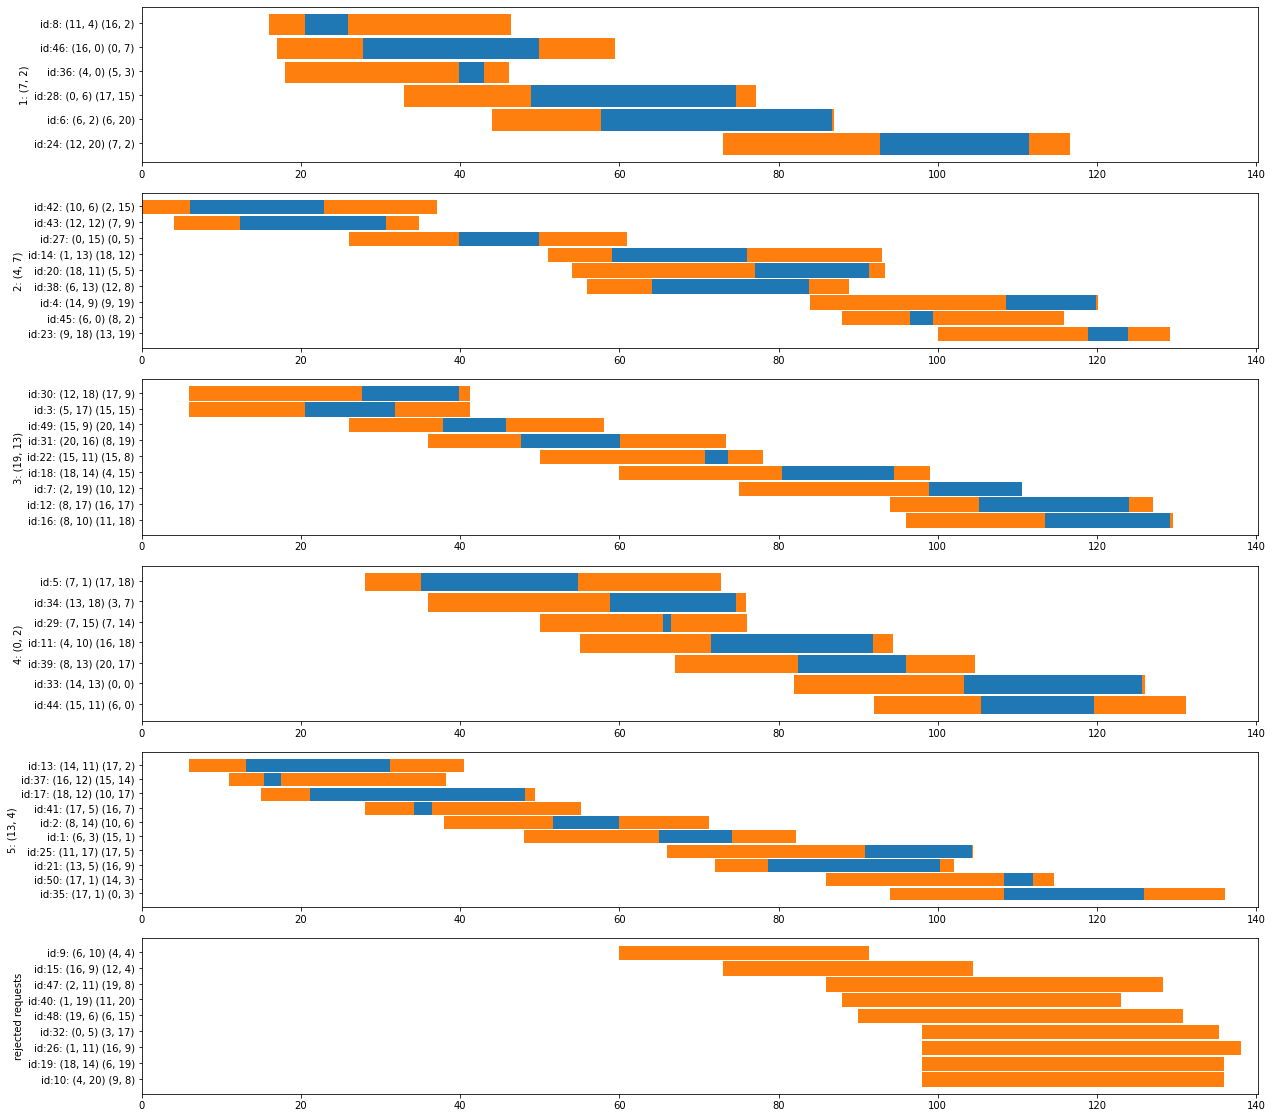

In [20]:
groß.visualize_tours()